In [12]:
import pandas as pd
import graph_ruggedness_de
import numpy as np
import random
import sequence_evolution
import solution_space_simulation
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
import gaussian_markov_random_field

## Figure 5

The purpose of Figure 5 is to demonstrate that the ruggedness of a fitness map with constant degree is dictated / bounded by the size of the solution space, that is, the number of edges that connect nodes with fitness above a selectable threshold. This is done using sequence space simulation from `sequence_evolution` and Fiedler-based spectral clustering from `solution_space_simulation`.

The below cell performs a sequence evolution simulation using `sequence_evolution.sequence_evolution` with realistic evolutionary parameters. This determines the fitness landscape topology to assess solution space over. 

In [2]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(1):
    #Sample evolutionary parameters.
    num_nodes = 500
    #num_nodes = np.random.randint(200, 1000)
    mean_branch_length = np.random.uniform(0.01, 0.5)
    std_dev_branch_length = np.random.uniform(0.001, 0.1)
    alpha = np.random.uniform(0.1, 0.5)
    model = random.choice(('WAG', 'LG'))
    rate_categoies = 4
    sequence_length = int(np.random.uniform(100, 600))

    sample_info = {
        'num_nodes' : num_nodes,
        'mean_branch_length' : mean_branch_length,
        'std_dev_branch_length' : std_dev_branch_length,
        'alpha' : alpha,
        'model' : model,
        'sequence_length' : sequence_length
    }

    #Perform sequence evolution.
    seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                    mean_branch_length=mean_branch_length,
                                                    std_dev_branch_length=std_dev_branch_length,
                                                    alpha=alpha,
                                                    model=model,
                                                    rate_categories=rate_categoies,
                                                    sequence_length=sequence_length
                                                    )
    #Construct graph from simulated sequences.

    seq_ls = list(seq_dict.values())
    values = [0]*len(seq_ls)
    G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values)

Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 11000 KNN edges.


The below cell uses spectral clustering functions `solution_space_simulation.spectral_cluster` and `solution_space_simulation.assign_clustered_values` to cluster nodes in the fitness landscape `G` according to graph topology. By increasing the number of clusters, `k`, the size of the cluster decreases, therefore reducing the size of the solution space over `G`. `solution_space_simulation.count_deltaS` and `solution_space_simulation.count_epsilonS` are used to count the number of edges that are separated by the solution space boundary and are within the solution space set, respectively. 

In [43]:
energies_dict = {}
delta_s_dict = {}
epsilon_s_dict = {}
solution_size_dict = {}

for replicate in range(10):

    dir_energies = []
    delta_s = []
    epsilon_s = []
    solution_size = []

    for clusters in range(2,20):

        G_clstr = solution_space_simulation.spectral_cluster(G=G,
                                                            k=clusters)

        G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)

        values = [node[1]['value'] for node in G_clstr.nodes(data=True)]

        solution_size.append(values.count(1))

        viridis = plt.cm.get_cmap('viridis', 10)

        laplacian = nx.laplacian_matrix(G_clstr).toarray()
        dir_en = values @ laplacian @ values
        
        dir_energies.append(dir_en)

        inter_s = solution_space_simulation.count_deltaS(G=G_clstr)
        intra_s = solution_space_simulation.count_epsilonS(G=G_clstr)

        delta_s.append(inter_s)
        epsilon_s.append(intra_s)
    
    energies_dict[replicate] = dir_energies
    delta_s_dict[replicate] = delta_s
    epsilon_s_dict[replicate] = epsilon_s
    solution_size_dict[replicate] = solution_size

/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_7542/3318133531.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_7542/331813

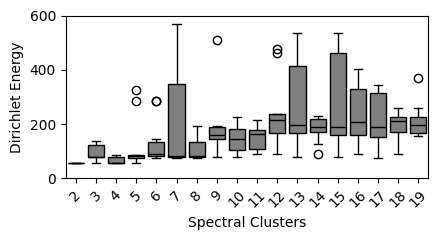

In [73]:
data_list = []
for replicate in energies_dict:
    observations = energies_dict[replicate]
    for index, obs in enumerate(observations):
        data_list.append({'Spectral Clusters': index+2, 'Dirichlet Energy': obs})

df = pd.DataFrame(data_list)

fig = plt.figure(figsize=(4.5,2.5))
sns.boxplot(x='Spectral Clusters', y='Dirichlet Energy', data=df, color='grey', linecolor='black')
# Display the plot
plt.ylim(0,600)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_a.pdf')

plt.show()

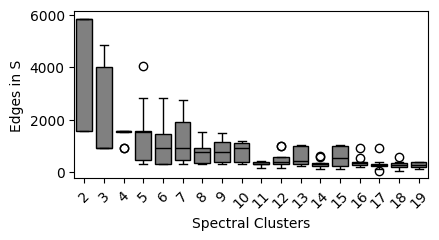

In [72]:
data_list = []
for replicate in epsilon_s_dict:
    observations = epsilon_s_dict[replicate]
    for index, obs in enumerate(observations):
        data_list.append({'Spectral Clusters': index+2, 'Edges in S': obs})

df = pd.DataFrame(data_list)

fig = plt.figure(figsize=(4.5,2.5))
sns.boxplot(x='Spectral Clusters', y='Edges in S', data=df, color='grey', linecolor='black')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_b.pdf')
plt.show()

## Plotting the fitness landscape as an interpolation over a graph surface

The cells below visually demonstrate how the solution space size (specifically the size of the edges in the solution space) dictates the ruggedness of the fitness function intuitively by Dirichlet energy. 

/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_7542/3016320327.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


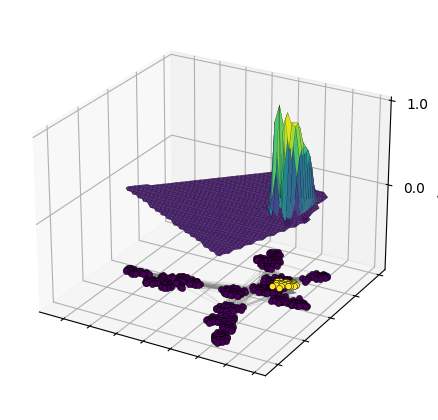

In [208]:
G = G_clstr
pos = nx.spring_layout(G, seed=42) 

signal = {n: G.nodes[n]['value'] for n in G.nodes()}

xs = np.array([pos[n][0] for n in G.nodes()])
ys = np.array([pos[n][1] for n in G.nodes()])
zs = np.array([signal[n] for n in G.nodes()])

grid_res = 50
x_lin = np.linspace(xs.min() - 0.1, xs.max() + 0.1, grid_res)
y_lin = np.linspace(ys.min() - 0.1, ys.max() + 0.1, grid_res)
X, Y = np.meshgrid(x_lin, y_lin)

Z = griddata((xs, ys), zs, (X, Y), method='cubic')

fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot(111, projection='3d')

signal_values = zs
norm = mpl.colors.Normalize(vmin=signal_values.min(), vmax=signal_values.max())
cmap = cm.get_cmap('viridis')
node_colors = [cmap(norm(signal[n])) for n in G.nodes()]

node_z_loc_dict = {
    0: 0,
    1: 0.1
}
node_z_loc = [node_z_loc_dict[val] for val in zs]

for i, n in enumerate(G.nodes()):
    x, y = pos[n]
    ax.scatter(x, y, node_z_loc[i], color=node_colors[i], s=20, edgecolor='black', linewidth=0.35)

for u, v in G.edges():
    x_vals = [pos[u][0], pos[v][0]]
    y_vals = [pos[u][1], pos[v][1]]
    z_vals = [0, 0]
    ax.plot(x_vals, y_vals, z_vals, color='grey', alpha=0.5, linewidth=0.25)

if np.any(np.isnan(Z)):
    Z = np.ma.array(Z, mask=np.isnan(Z))

offset = 1
surf = ax.plot_surface(X, Y, Z + offset, cmap='viridis', alpha=1, edgecolor='black', linewidth=0.1)

# cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
# cbar.set_label("Fitness")

ax.view_init(elev=25, azim=-60)

max_signal_val = signal_values.max()
ax.set_zlim(0, offset + max_signal_val)
z_tick_start = offset
z_tick_end = offset + np.ceil(max_signal_val)
ax.set_zticks(np.arange(z_tick_start, z_tick_end + 1, 1))
def z_formatter(val, pos):
    return f"{val - offset:.1f}"

ax.zaxis.set_major_formatter(FuncFormatter(z_formatter))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zlabel('Fitness')
plt.savefig('../figures/figure_5/panel_d.pdf')

plt.tight_layout()
plt.show()


/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_7542/2970065589.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


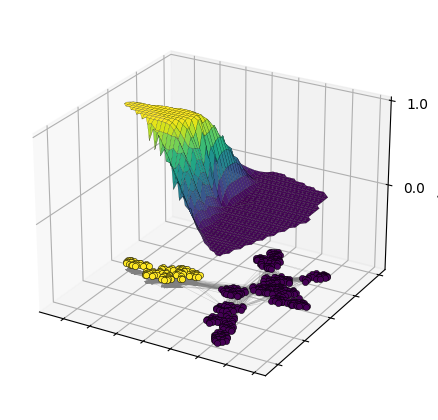

In [212]:
G_clstr = solution_space_simulation.spectral_cluster(G=G,
                                                    k=2)

G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)

G = G_clstr
pos = nx.spring_layout(G, seed=42) 

signal = {n: G.nodes[n]['value'] for n in G.nodes()}

xs = np.array([pos[n][0] for n in G.nodes()])
ys = np.array([pos[n][1] for n in G.nodes()])
zs = np.array([signal[n] for n in G.nodes()])

grid_res = 50
x_lin = np.linspace(xs.min() - 0.1, xs.max() + 0.1, grid_res)
y_lin = np.linspace(ys.min() - 0.1, ys.max() + 0.1, grid_res)
X, Y = np.meshgrid(x_lin, y_lin)

Z = griddata((xs, ys), zs, (X, Y), method='cubic')

fig = plt.figure(figsize=(4.5,4.5))
ax = fig.add_subplot(111, projection='3d')

signal_values = zs
norm = mpl.colors.Normalize(vmin=signal_values.min(), vmax=signal_values.max())
cmap = cm.get_cmap('viridis')
node_colors = [cmap(norm(signal[n])) for n in G.nodes()]

node_z_loc_dict = {
    0: 0,
    1: 0.1
}
node_z_loc = [node_z_loc_dict[val] for val in zs]

for i, n in enumerate(G.nodes()):
    x, y = pos[n]
    ax.scatter(x, y, node_z_loc[i], color=node_colors[i], s=20, edgecolor='black', linewidth=0.35)

for u, v in G.edges():
    x_vals = [pos[u][0], pos[v][0]]
    y_vals = [pos[u][1], pos[v][1]]
    z_vals = [0, 0]
    ax.plot(x_vals, y_vals, z_vals, color='grey', alpha=0.5, linewidth=0.25)

if np.any(np.isnan(Z)):
    Z = np.ma.array(Z, mask=np.isnan(Z))

offset = 1
surf = ax.plot_surface(X, Y, Z + offset, cmap='viridis', alpha=1, edgecolor='black', linewidth=0.1)

# cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
# cbar.set_label("Fitness")

ax.view_init(elev=25, azim=-60)

max_signal_val = signal_values.max()
ax.set_zlim(0, offset + max_signal_val)
z_tick_start = offset
z_tick_end = offset + np.ceil(max_signal_val)
ax.set_zticks(np.arange(z_tick_start, z_tick_end + 1, 1))
def z_formatter(val, pos):
    return f"{val - offset:.1f}"

ax.zaxis.set_major_formatter(FuncFormatter(z_formatter))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zlabel('Fitness')

plt.savefig('../figures/figure_5/panel_c.pdf')

plt.tight_layout()
plt.show()

## Experimental system: DAOx 

Added 67998 Hamming edges.
Added 67998 Hamming edges.


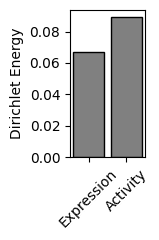

In [13]:
df = pd.read_csv('../data_files/doax/DOAx_activity.csv')
df = df.dropna()
seq_ls = df['sequence'].tolist()
values = df['fitness'].tolist()
scaler = MinMaxScaler()


# Build graph and compute metrics
G_fitness = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)
#Add single mutation edges
graph_ruggedness_de.add_hamming_edges(G_fitness, threshold=1)

de_fitness = graph_ruggedness_de.compute_dirichlet_energy(G=G_fitness)

values = df['expression'].tolist()

# Build graph and compute metrics
G_expression = graph_ruggedness_de.build_ohe_graph(
    seq_ls=seq_ls,
    values=values,
    edges=False,
)
#Add single mutation edges
graph_ruggedness_de.add_hamming_edges(G_expression, threshold=1)


de_expression = graph_ruggedness_de.compute_dirichlet_energy(G=G_expression)

fig = plt.figure(figsize=(1.65, 2.5))

plt.bar(x=['Expression', 'Activity'],
        height=[de_expression/G_fitness.number_of_edges(), de_fitness/G_fitness.number_of_edges()],
        color='grey',
        edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel('Dirichlet Energy')
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_e.pdf')
plt.show()

expression_log_likelihood = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_expression,
                                                                        t0=5,
                                                                        standardise=False)

activity_log_likelihood = gaussian_markov_random_field.compute_gmrf_ruggedness(G=G_fitness,
                                                                        t0=5,
                                                                        standardise=False)

# #Plotting graphs
# sampled_graph = graph_ruggedness_de.sample_graph(G=G_fitness, sample_size=1)[0]

# values = [node[1]['value'] for node in sampled_graph.nodes(data=True)]
# viridis = plt.cm.get_cmap('viridis', 10)

# pos = nx.spring_layout(sampled_graph, k=0.05)

# nodes_sorted_by_value = sorted(sampled_graph.nodes(data=True), key=lambda x: x[1]['value'])
# node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
# nodes_sorted = [node[0] for node in nodes_sorted_by_value]

# fig, ax = plt.subplots(figsize=(3.15, 2.5), constrained_layout=True)
# plt.tight_layout()
# nx.draw(sampled_graph, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75)
# sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
# sm.set_array([])  # This is needed to avoid a warning

# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Activity')

# plt.tight_layout()
# plt.savefig('../figures/figure_5/panel_f.pdf')
# plt.show()

# sampled_graph = graph_ruggedness_de.sample_graph(G=G_expression, sample_size=1)[0]

# values = [node[1]['value'] for node in sampled_graph.nodes(data=True)]
# viridis = plt.cm.get_cmap('viridis', 10)

# pos = nx.spring_layout(sampled_graph, k=0.005)

# nodes_sorted_by_value = sorted(sampled_graph.nodes(data=True), key=lambda x: x[1]['value'])
# node_colors = [viridis((node[1]['value'] - min(values)) / (max(values) - min(values))) for node in nodes_sorted_by_value]
# nodes_sorted = [node[0] for node in nodes_sorted_by_value]

# fig, ax = plt.subplots(figsize=(3.15, 2.5), constrained_layout=True)
# plt.tight_layout()
# nx.draw(sampled_graph, pos, nodelist=nodes_sorted, node_color=node_colors, with_labels=False, edgecolors='black', node_size=25, width=0.5, edge_color='#C6C6C6', linewidths=0.75)
# sm = mpl.cm.ScalarMappable(cmap=viridis, norm=plt.Normalize(vmin=min(values), vmax=max(values)))
# sm.set_array([])  # This is needed to avoid a warning
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Expression')

# plt.tight_layout()
# plt.savefig('../figures/figure_5/panel_g.pdf')
# plt.show()


In [14]:
expression_log_likelihood

(-7249.281499244409, -33184.80037376597, 35147.20390227664)

In [15]:
activity_log_likelihood

(-4749.432953340627, -30181.460080922596, 27144.166517625705)

## DAOx solution spaces for expression and catalytic activity

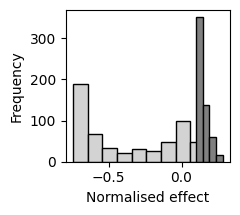

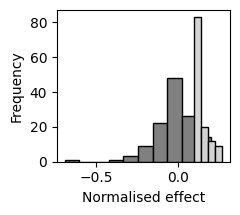

In [234]:
data = pd.read_csv('../data_files/doax/DOAx_activity.csv')
wt = data[data['fitness'] == 0]

improved_expression = data[data['expression'] > 0.1]
improved_fitness = data[data['fitness'] > 0.1]

fig = plt.figure(figsize=(2.5, 2.25))
plt.hist(improved_expression['fitness'], color='lightgrey', edgecolor='black')
plt.hist(improved_expression['expression'], color='grey', edgecolor='black', bins=4)
plt.xlabel('Normalised effect')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_h.pdf')

fig = plt.figure(figsize=(2.5, 2.25))
plt.hist(improved_fitness['expression'], color='grey', edgecolor='black')
plt.hist(improved_fitness['fitness'], color='lightgrey', edgecolor='black', bins=4)
plt.xlabel('Normalised effect')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_i.pdf')